In [1]:
import os
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import librosa.display
import IPython.display as ipd

## Reading Dataset

In [3]:
import pandas as pd
df1=pd.read_excel('Healthy_data.xlsx')
df2=pd.read_excel('Pathological_data.xlsx')
df=pd.concat([df1,df2], ignore_index=True)
df.head(10)

,Recording Id,Type,Gender,Age,Diagnosis Notes,Pathology,Audio
0,1,n,w,20,Normal,Normal,1-a_n.wav
1,2,n,w,22,Normal,Normal,2-a_n.wav
2,3,n,w,23,Normal,Normal,3-a_n.wav
3,4,n,m,22,Normal,Normal,4-a_n.wav
4,5,n,m,22,Normal,Normal,5-a_n.wav
5,6,n,w,20,Normal,Normal,6-a_n.wav
6,7,n,w,19,Normal,Normal,7-a_n.wav
7,27,n,w,20,Normal,Normal,27-a_n.wav
8,17,n,w,19,Normal,Normal,17-a_n.wav
9,8,n,w,19,Normal,Normal,8-a_n.wav


In [4]:
df.shape

(1490, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Recording Id     1490 non-null   int64 
 1   Type             1490 non-null   object
 2   Gender           1490 non-null   object
 3   Age              1490 non-null   int64 
 4   Diagnosis Notes  1400 non-null   object
 5   Pathology        1490 non-null   object
 6   Audio            1490 non-null   object
dtypes: int64(2), object(5)
memory usage: 81.6+ KB


In [6]:
type_gender_count = df.groupby(["Type","Gender"])[['Audio']].count()
type_gender_count

Audio
Type Gender       
n    m         259
     w         428
p    m         302
     w         501

<Axes: xlabel='Type,Gender'>

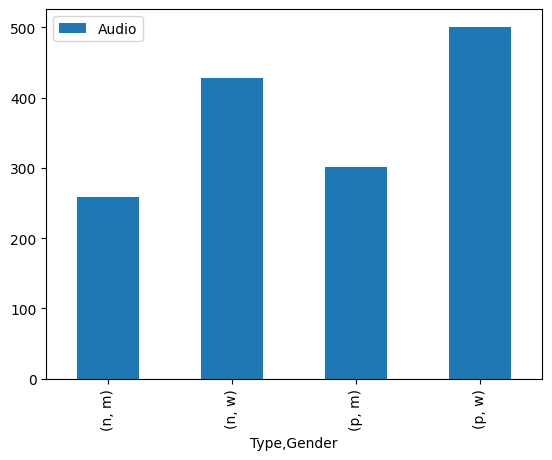

In [7]:
type_gender_count.plot.bar()

### Frequency plot for Gender vs pathological category

In [8]:
gender = df.Gender.unique()
pathology = df.Pathology.unique()
print(gender)
print(pathology)

['w' 'm']
['Normal' 'Dysphonia' 'Laryngitis' 'Recurrent palsy']


In [9]:
# Finding fft and converting it to power spectrum
def fft_calculation(data, i, j):
    fft = np.fft.fft(data)
    magnitude = np.abs(fft)
    frequency = np.linspace(0, sample_rate, len(magnitude))
    
    left_frequency = frequency[:int(len(frequency)/2)]
    left_magnitude = magnitude[:int(len(frequency)/2)]
    print(str(gender[i])+" vs "+str(pathology[j])+" :- "+str(left_frequency[np.where(left_magnitude == max(left_magnitude))[0][0]]))

    axes[i][j].plot(left_frequency, left_magnitude)
    plt.xlabel("Frequency")  # Set x-label
    plt.ylabel("Magnitude")  # Set y-label

w vs Normal :- 820.1834221735993
w vs Dysphonia :- 215.92833058325562
w vs Laryngitis :- 202.63897956109076
w vs Recurrent palsy :- 264.022450888681
m vs Normal :- 610.5449591280654
m vs Dysphonia :- 586.2829478214094
m vs Laryngitis :- 663.8532110091744
m vs Recurrent palsy :- 95.64965592423519


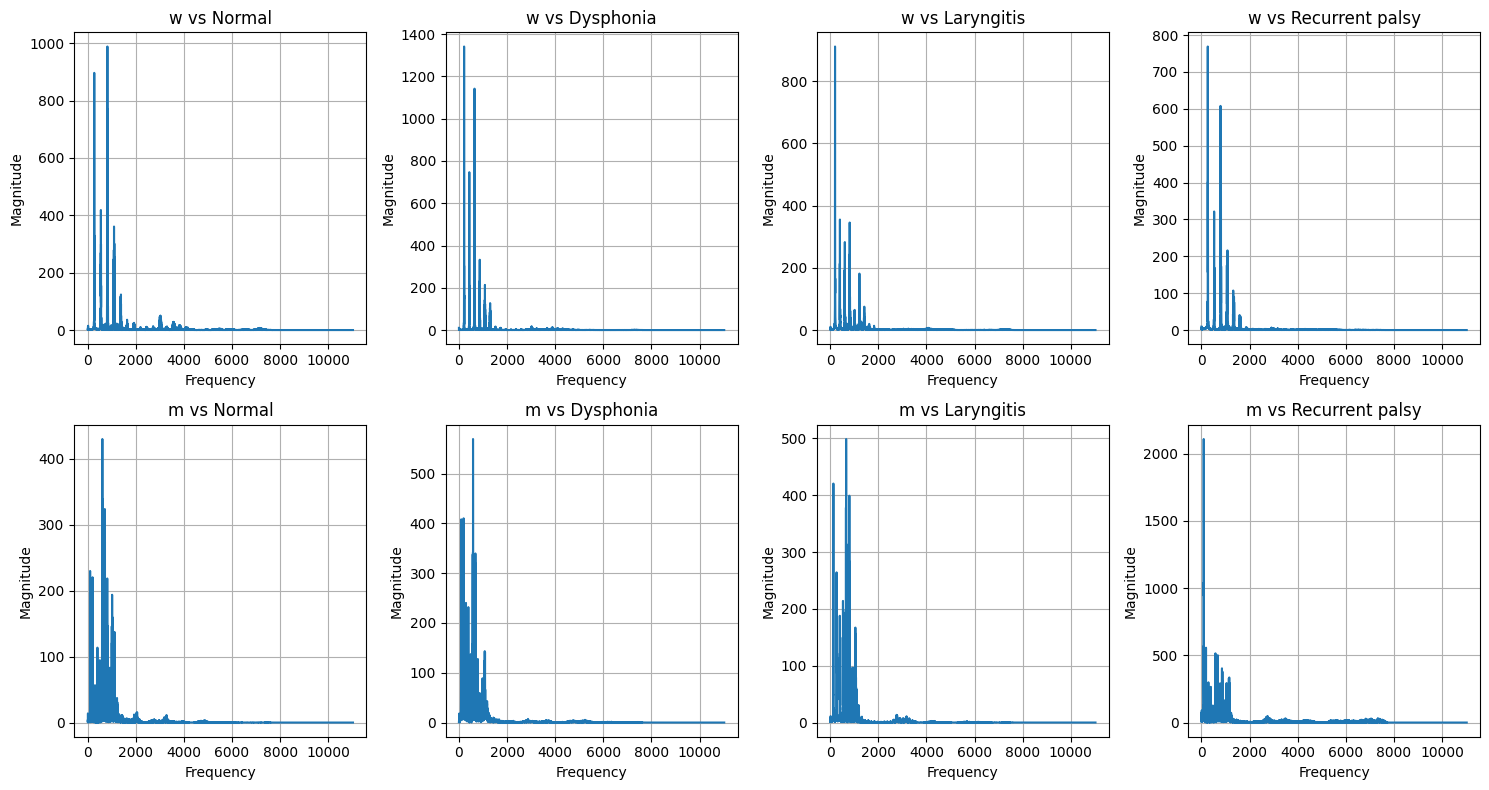

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8), squeeze=False)

for i in range(2):
    for j in range(4):
        gender_pathological_df = df[np.logical_and(df.Gender==gender[i],df.Pathology==pathology[j])]
        data, sample_rate = librosa.load("Filtered_Audio_Dataset/"+gender_pathological_df.Audio.values[0])
        fft_calculation(data, i, j)
        plt.sca(axes[i][j])
        plt.title(str(gender[i])+" vs "+str(pathology[j]))
        plt.tight_layout()
        plt.grid(True)

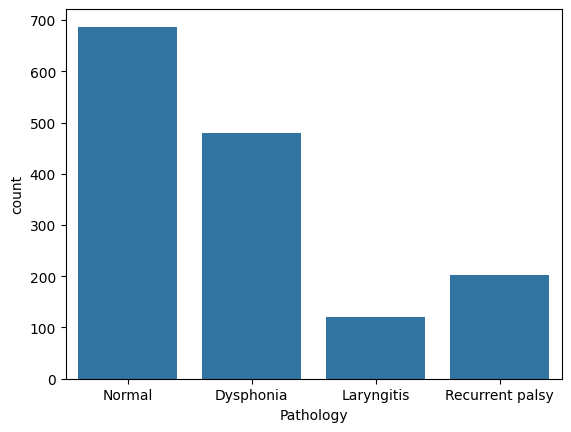

In [11]:
sns.countplot(x=df["Pathology"])
plt.show()

<Axes: xlabel='Type', ylabel='count'>

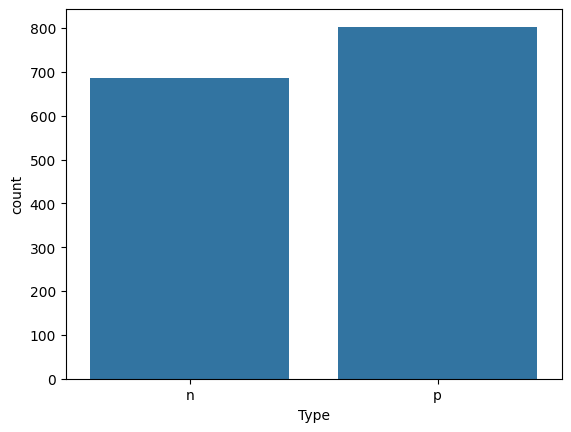

In [12]:
sns.countplot(x=df['Type'])

In [13]:
df["Age"].value_counts().sort_values(ascending= False).head(10)

Age
20    123
21     94
22     69
19     66
23     50
36     45
59     33
60     32
32     30
24     30
Name: count, dtype: int64

<Axes: ylabel='Density'>

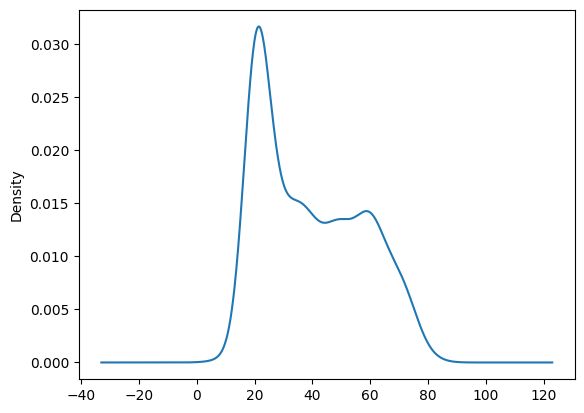

In [14]:
df["Age"].plot.kde()

## Extract Features

In [15]:
mfccs = librosa.feature.mfcc(y=data, sr= sample_rate, n_mfcc=80)
print(mfccs.shape)

(80, 87)


In [16]:
mfccs

array([[-113.613    ,  -89.01245  ,  -96.09805  , ..., -122.339096 ,
        -115.17272  , -131.32349  ],
       [ 143.46376  ,  152.82028  ,  162.12552  , ...,  148.42282  ,
         145.6359   ,  137.04434  ],
       [  -3.917379 ,  -19.928009 ,  -27.019974 , ...,  -30.516018 ,
         -25.041967 ,   -8.090624 ],
       ...,
       [  -5.252745 ,   -1.0948491,    2.6629157, ...,    7.357658 ,
           6.5301757,    4.1670647],
       [  -4.2366934,    1.1966839,    4.222116 , ...,    9.093587 ,
           5.7590275,    2.0302086],
       [  -2.3465881,   -4.0526004,   -4.7780204, ...,    5.0549297,
           2.9839945,    0.2255072]], dtype=float32)

In [17]:
## Extracting MFCC's for every audio file
import pandas as pd
import os

audio_dataset_path = 'Filtered_Audio_Dataset/'

In [18]:
def features_extraction(file):
    audio, sample_rate = librosa.load(file_name)
    mfccs_features = librosa.feature.mfcc(y=audio, sr= sample_rate, n_mfcc=80)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    
    return mfccs_scaled_features

In [19]:
import numpy as np
from tqdm import tqdm

extracted_features=[]
for index_num,row in tqdm(df.iterrows()):
    file_name = audio_dataset_path+row["Audio"]
    final_class_labels = row["Pathology"]
    data = features_extraction(file_name)
    extracted_features.append([data,final_class_labels])

1490it [00:21, 68.65it/s] 


In [20]:
extracted_features_df = pd.DataFrame(extracted_features, columns=['feature','class'])
extracted_features_df.head(10)

,feature,class
0,"[-261.49933, 114.805534, -72.840965, -0.931277...",Normal
1,"[-202.87245, 145.96022, -68.10183, -11.444383,...",Normal
2,"[-167.76535, 133.49133, -77.94643, -9.826728, ...",Normal
3,"[-279.40063, 208.5046, -43.03498, -5.360972, -...",Normal
4,"[-172.24774, 175.08725, -75.93269, 8.99103, -6...",Normal
5,"[-205.02122, 137.12006, -66.55497, -12.496069,...",Normal
6,"[-217.24478, 145.07858, -100.58555, 2.7787614,...",Normal
7,"[-227.11813, 127.75929, -63.862732, -13.961372...",Normal
8,"[-196.28305, 113.32672, -99.92175, 1.0585632, ...",Normal
9,"[-207.56131, 135.24808, -61.779488, -17.637135...",Normal


In [21]:
extracted_features_df.shape

(1490, 2)

In [22]:
extracted_features_df["feature"][0]

array([-2.61499329e+02,  1.14805534e+02, -7.28409653e+01, -9.31277871e-01,
       -6.87778549e+01, -2.90463376e+00,  4.69877529e+00,  7.56695986e+00,
       -3.33707962e+01,  1.76828156e+01, -4.03612089e+00, -1.42697287e+01,
        9.20465565e+00, -2.80942898e+01, -1.00394077e+01, -1.63144569e+01,
       -9.73753095e-01, -4.31138134e+00, -9.75323021e-01, -1.19480648e+01,
        4.30604649e+00, -9.05258274e+00,  8.25730264e-02,  4.08039131e+01,
        2.39141750e+01,  6.14854851e+01,  3.20326614e+01,  8.02177048e+00,
       -2.74810147e+00, -9.03449821e+00,  4.29856348e+00, -1.17523634e+00,
        1.33330641e+01, -6.40946245e+00, -1.52622843e+01, -5.44703770e+00,
        1.03529129e+01, -3.11023307e+00, -8.39600277e+00, -7.93014669e+00,
       -5.57793570e+00,  1.33628864e+01, -4.67780113e+00, -1.73656483e+01,
       -1.20797033e+01,  3.30997729e+00, -6.23456812e+00,  1.79914856e+00,
        1.81635227e+01,  3.11546078e+01,  3.39731293e+01,  2.36189723e+00,
        3.56650442e-01,  

In [23]:
## Label Encoding
dummy_data = pd.get_dummies(extracted_features_df['class'])

In [24]:
dummy_data

,Dysphonia,Laryngitis,Normal,Recurrent palsy
0,False,False,True,False
1,False,False,True,False
2,False,False,True,False
3,False,False,True,False
4,False,False,True,False
...,...,...,...,...
1485,False,False,False,True
1486,False,False,False,True
1487,False,False,False,True
1488,False,False,False,True


In [25]:
x=np.array(extracted_features_df['feature'].values.tolist())
y=dummy_data

In [26]:
x.shape

(1490, 80)

In [27]:
y.shape

(1490, 4)

In [28]:
### Train Test Split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify= y, test_size=0.2,random_state=0)

In [29]:
x_train.shape

(1192, 80)

In [30]:
x_test.shape

(298, 80)

In [31]:
y_train.shape

(1192, 4)

In [32]:
y_test.shape

(298, 4)

## Model Training

In [33]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [35]:
## No. of classes
num_labels=y.shape[1]
num_labels

4

In [36]:
model=Sequential()
## first layer
model.add(Dense(256,input_shape=(80,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
## second layer
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
## third layer
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
## final Layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [37]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               20736     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               1

In [39]:
## Training my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs=150
num_batch_size=32

checkpointer=ModelCheckpoint(filepath='/audio_classification.hdf5', verbose=1, save_best_only=True)
start=datetime.now()

model.fit(x_train,y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test,y_test), callbacks=[checkpointer])
duration=datetime.now()-start

print("Training completed in time: ",duration)

Epoch 1/150
33/38 [=========================>....] - ETA: 0s - loss: 16.5500 - accuracy: 0.3494
Epoch 1: val_loss improved from inf to 2.03768, saving model to /audio_classification.hdf5
38/38 [==============================] - 3s 37ms/step - loss: 15.8937 - accuracy: 0.3465 - val_loss: 2.0377 - val_accuracy: 0.4530
Epoch 2/150
19/38 [==============>...............] - ETA: 0s - loss: 7.2520 - accuracy: 0.4243

C:\Anaconda\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/38 [=======================>......] - ETA: 0s - loss: 7.1050 - accuracy: 0.3931
Epoch 2: val_loss improved from 2.03768 to 1.40622, saving model to /audio_classification.hdf5
38/38 [==============================] - 0s 8ms/step - loss: 6.8568 - accuracy: 0.3867 - val_loss: 1.4062 - val_accuracy: 0.3389
Epoch 3/150
38/38 [==============================] - ETA: 0s - loss: 4.1896 - accuracy: 0.3532
Epoch 3: val_loss improved from 1.40622 to 1.18190, saving model to /audio_classification.hdf5
38/38 [==============================] - 0s 9ms/step - loss: 4.1896 - accuracy: 0.3532 - val_loss: 1.1819 - val_accuracy: 0.4597
Epoch 4/150
32/38 [========================>.....] - ETA: 0s - loss: 2.9394 - accuracy: 0.3643
Epoch 4: val_loss did not improve from 1.18190
38/38 [==============================] - 0s 7ms/step - loss: 2.8934 - accuracy: 0.3633 - val_loss: 1.2306 - val_accuracy: 0.4597
Epoch 5/150
36/38 [===========================>..] - ETA: 0s - loss: 2.1420 - accuracy: 0.3976
Epoch 5:

Epoch 32/150
37/38 [============================>.] - ETA: 0s - loss: 1.1934 - accuracy: 0.4544
Epoch 32: val_loss did not improve from 1.18190
38/38 [==============================] - 0s 8ms/step - loss: 1.1944 - accuracy: 0.4539 - val_loss: 1.2064 - val_accuracy: 0.4597
Epoch 33/150
34/38 [=========================>....] - ETA: 0s - loss: 1.1814 - accuracy: 0.4449
Epoch 33: val_loss did not improve from 1.18190
38/38 [==============================] - 0s 6ms/step - loss: 1.1855 - accuracy: 0.4505 - val_loss: 1.1976 - val_accuracy: 0.4597
Epoch 34/150
35/38 [==========================>...] - ETA: 0s - loss: 1.1643 - accuracy: 0.4670
Epoch 34: val_loss did not improve from 1.18190
38/38 [==============================] - 0s 6ms/step - loss: 1.1710 - accuracy: 0.4606 - val_loss: 1.1949 - val_accuracy: 0.4597
Epoch 35/150
35/38 [==========================>...] - ETA: 0s - loss: 1.1708 - accuracy: 0.4518
Epoch 35: val_loss did not improve from 1.18190
38/38 [==============================

Epoch 61/150
35/38 [==========================>...] - ETA: 0s - loss: 1.1173 - accuracy: 0.4955
Epoch 61: val_loss did not improve from 1.15292
38/38 [==============================] - 0s 7ms/step - loss: 1.1170 - accuracy: 0.4975 - val_loss: 1.1607 - val_accuracy: 0.4597
Epoch 62/150
35/38 [==========================>...] - ETA: 0s - loss: 1.1178 - accuracy: 0.4964
Epoch 62: val_loss did not improve from 1.15292
38/38 [==============================] - 0s 6ms/step - loss: 1.1137 - accuracy: 0.4933 - val_loss: 1.1622 - val_accuracy: 0.4698
Epoch 63/150
35/38 [==========================>...] - ETA: 0s - loss: 1.1163 - accuracy: 0.5000
Epoch 63: val_loss did not improve from 1.15292
38/38 [==============================] - 0s 6ms/step - loss: 1.1212 - accuracy: 0.5017 - val_loss: 1.1628 - val_accuracy: 0.4866
Epoch 64/150
35/38 [==========================>...] - ETA: 0s - loss: 1.0973 - accuracy: 0.5000
Epoch 64: val_loss did not improve from 1.15292
38/38 [==============================

38/38 [==============================] - 0s 7ms/step - loss: 1.0282 - accuracy: 0.5680 - val_loss: 1.1458 - val_accuracy: 0.4966
Epoch 90/150
34/38 [=========================>....] - ETA: 0s - loss: 1.0296 - accuracy: 0.5754
Epoch 90: val_loss did not improve from 1.10547
38/38 [==============================] - 0s 6ms/step - loss: 1.0221 - accuracy: 0.5755 - val_loss: 1.1317 - val_accuracy: 0.5201
Epoch 91/150
33/38 [=========================>....] - ETA: 0s - loss: 0.9915 - accuracy: 0.5682
Epoch 91: val_loss did not improve from 1.10547
38/38 [==============================] - 0s 7ms/step - loss: 0.9837 - accuracy: 0.5755 - val_loss: 1.1283 - val_accuracy: 0.5436
Epoch 92/150
33/38 [=========================>....] - ETA: 0s - loss: 0.9708 - accuracy: 0.5748
Epoch 92: val_loss did not improve from 1.10547
38/38 [==============================] - 0s 6ms/step - loss: 0.9710 - accuracy: 0.5789 - val_loss: 1.1352 - val_accuracy: 0.5436
Epoch 93/150
36/38 [===========================>..] 

38/38 [==============================] - 0s 8ms/step - loss: 0.8821 - accuracy: 0.6342 - val_loss: 1.1718 - val_accuracy: 0.5537
Epoch 120/150
30/38 [======================>.......] - ETA: 0s - loss: 0.8171 - accuracy: 0.6552
Epoch 120: val_loss did not improve from 1.10547
38/38 [==============================] - 0s 7ms/step - loss: 0.8364 - accuracy: 0.6460 - val_loss: 1.1775 - val_accuracy: 0.5470
Epoch 121/150
34/38 [=========================>....] - ETA: 0s - loss: 0.8040 - accuracy: 0.6645
Epoch 121: val_loss did not improve from 1.10547
38/38 [==============================] - 0s 7ms/step - loss: 0.8086 - accuracy: 0.6628 - val_loss: 1.2022 - val_accuracy: 0.5570
Epoch 122/150
31/38 [=======================>......] - ETA: 0s - loss: 0.8165 - accuracy: 0.6552
Epoch 122: val_loss did not improve from 1.10547
38/38 [==============================] - 0s 7ms/step - loss: 0.8190 - accuracy: 0.6577 - val_loss: 1.1432 - val_accuracy: 0.5503
Epoch 123/150
35/38 [=========================

In [40]:
test_accuracy=model.evaluate(x_test,y_test,verbose=0)
print(test_accuracy[1])

0.5536912679672241


10/10 [==============================] - 0s 4ms/step


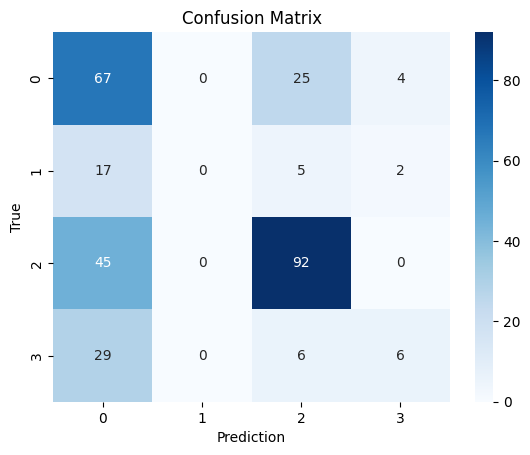

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

#compute confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

#Plot confusion matrix
sns.heatmap( conf_matrix, annot=True, fmt='d', cmap= 'Blues')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Model Evaluation

In [41]:
filename = 'Audio_Dataset/101-a_n.wav'

In [42]:
feature_df = pd.DataFrame(features_extraction(filename)).transpose()

In [43]:
feature_df

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,-182.332748,138.173431,-84.687096,10.047243,-48.317905,9.40225,2.296518,4.65991,-13.330125,9.432405,...,-3.532734,1.599048,2.740876,-0.671063,1.497601,-0.059052,-2.493449,-0.113035,5.037437,-0.590547


In [44]:
features = np.array(feature_df.values.tolist())

In [45]:
features.shape

(1, 80)

In [46]:
model.predict(features)

1/1 [==============================] - 0s 95ms/step


array([[0.4223226 , 0.1670914 , 0.23075259, 0.17983349]], dtype=float32)